In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score

# Part A : Data Preparation and Baseline

1. Load and Prepare the Data

In [6]:
!unzip /content/statlog+landsat+satellite.zip

Archive:  /content/statlog+landsat+satellite.zip
  inflating: Index                   
  inflating: sat.doc                 
  inflating: sat.trn                 
  inflating: sat.tst                 


In [7]:
scaler=StandardScaler()

In [8]:
train=pd.read_csv('/content/sat.trn', sep=' ', header=None)
test=pd.read_csv('/content/sat.tst', sep=' ', header=None)
train=train.dropna(axis=1, how='all')
test=test.dropna(axis=1, how='all')

In [9]:
train

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,56,64,108,96,64,71,108,96,68,75,...,92,66,83,108,96,66,87,104,89,5
4431,64,71,108,96,68,75,108,96,71,87,...,96,66,87,104,89,63,87,104,89,5
4432,68,75,108,96,71,87,108,88,71,91,...,89,63,87,104,89,70,100,104,85,4
4433,71,87,108,88,71,91,100,81,76,95,...,89,70,100,104,85,70,91,104,85,4


2. Train Test split

In [10]:
X_train, y_train =train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [11]:
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

3. Train all Models

In [12]:
models = {
    "k_neighbors_classifier" : KNeighborsClassifier(),
    "decision_tree_classifier" : DecisionTreeClassifier(),
    "dummy_classifier" : DummyClassifier(strategy='prior'),
    "logistic_regression" : LogisticRegression(),
    "naive_bayes_classifier" : GaussianNB(),
    "svm_classifier" : SVC(probability=True)
}
results=[]
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred=model.predict(X_test_scaled)
    accuracy=accuracy_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred, average='weighted')
    results.append((name, accuracy, f1))
    print(f'The model {name} provides overall accuracy = {accuracy} and weighted F1 score = {f1}')

The model k_neighbors_classifier provides overall accuracy = 0.9045 and weighted F1 score = 0.9037478054556176
The model decision_tree_classifier provides overall accuracy = 0.8585 and weighted F1 score = 0.8600879824755939
The model dummy_classifier provides overall accuracy = 0.2305 and weighted F1 score = 0.08635554652580252
The model logistic_regression provides overall accuracy = 0.8395 and weighted F1 score = 0.8295946506799361
The model naive_bayes_classifier provides overall accuracy = 0.7965 and weighted F1 score = 0.8035812230688508
The model svm_classifier provides overall accuracy = 0.8955 and weighted F1 score = 0.8924904363139287


4. Baseline Evaluation

Based on the overall accuracy and weighted F1 score, the Dummy classifier performs the worst

# Part B : ROC Analysis for Model Selection

1. Multi-Class ROC Calculation

The One-vs-Rest approach enables the computation of ROC curves and AUC by converting the multi-class classification problem into multiple binary classification tasks. For each class, the model is trained to distinguish that class as the "positive" class against all other classes combined as the "negative" class. Thus, if there are N classes, OvR approach creates N separate binary classification tasks.

The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) across various thresholds and the corresponding AUC (Area under curve) is computed for each class. The AUC values can be averaged for all classes to assess the overall performance.

2. Plotting ROC

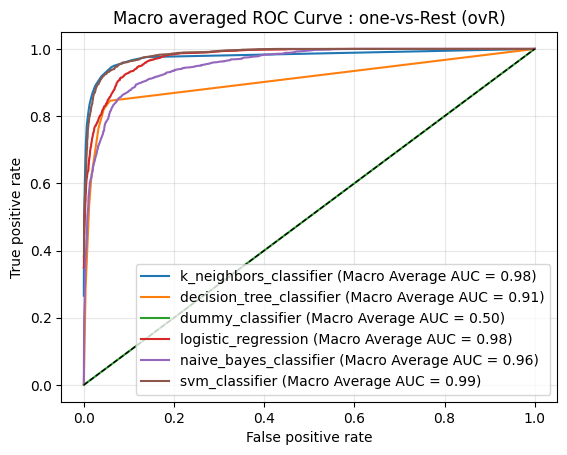

In [13]:
classes=np.unique(y_train)
y_test_bin=label_binarize(y_test, classes=classes)

plt.figure()
for name, model in models.items():
  model.fit(X_train_scaled, y_train)
  y_score=model.predict_proba(X_test_scaled)
  fpr_dict={}
  tpr_dict={}
  roc_auc_dict={}
  for i in range(len(classes)):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc_dict[i]=auc(fpr_dict[i], tpr_dict[i])
  all_fpr=np.unique(np.concatenate([fpr_dict[i] for i in range(len(classes))]))
  mean_tpr=np.zeros_like(all_fpr)
  for i in range(len(classes)):
    mean_tpr+=np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
  mean_tpr/=len(classes)
  roc_auc_macro=auc(all_fpr, mean_tpr)
  plt.plot(all_fpr, mean_tpr, label=f'{name} (Macro Average AUC = {roc_auc_macro:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Macro averaged ROC Curve : one-vs-Rest (ovR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Model with highest macro-averaged AUC = SVM Classifier (0.99)

ROC Interpretation

There is no model that exhibits an AUC < 0.5. However, the dummy classifier has an AUC exactly equal to 0.5. The Area Under the Curve (AUC) is a numerical value that represents the model's classification ability. An AUC score < 0.5 implies that the model is performing worse than random guessing. The dummy classifier having an AUC score = 0.5 implies that it's performance is as good as random guessing. The model can have AUC < 0.5 if it has inverted class labels, incorrect feature-label associations or strongly biased training data that leads to misleading predictions.

# Part C : Precision-Recall Curve (PRC) Analysis

1. PRC Calculation

The Precision-Recall Curve is often considered a more suitable metric than the ROC curve when evaluating classifiers on imbalanced datasets, due to its focus on minority class and insensitivity to the number of true negatives. ROC curves plot the true positive rate (TPR) against the false positive rate (FPR), which is heavily influenced by the large number of true negatives in the dataset. If the negative class data points are significantly large, the few false positives can lead to extremely low FPR, making the ROC curve appear optimistic. However, this does not imply that the model is performing well at identifying the minority class. The precision-recall curve illustrates the trade-off between identifying positive instances correctly (recall) and avoiding misclassifying negative instances as positive (precision), which provides a better picture of how the classifier is performing, even if the imbalance in the dataset is moderate.

2. Plotting PRC

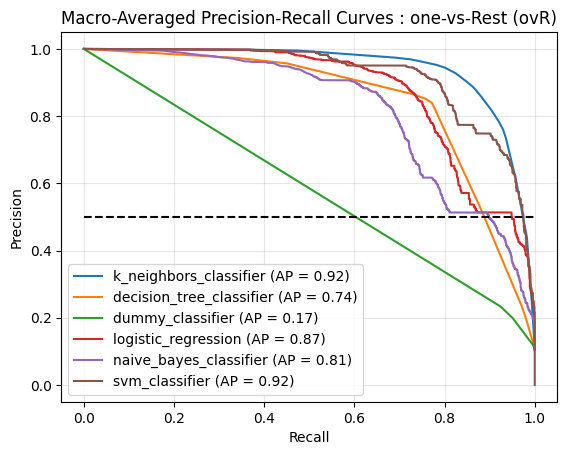

In [14]:
plt.figure()
for name, model in models.items():
  model.fit(X_train_scaled, y_train)
  y_score=model.predict_proba(X_test_scaled)
  precision=dict()
  recall=dict()
  avg_precision=dict()
  for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision[i]=average_precision_score(y_test_bin[:, i], y_score[:, i])

  all_precision=np.unique(np.concatenate([precision[i] for i in range(len(classes))]))
  mean_recall=np.zeros_like(all_precision)
  for i in range(len(classes)):
    mean_recall+=np.interp(all_precision, precision[i], recall[i])
  mean_recall/=len(classes)
  mean_ap=np.mean(list(avg_precision.values()))
  plt.plot(mean_recall, all_precision, label=f'{name} (AP = {mean_ap:.2f})')

plt.plot([0, 1], [0.5, 0.5], 'k--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision-Recall Curves : one-vs-Rest (ovR)")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

Model with highest average precision (AP) - SVM Classifier and K-Neighbors Classifier (0.92)

3. PRC Interpretation

The precision-recall curve of the worst performing model (dummy classifier) is almost linearly sloping downwards i.e the precision decreases proportionally to the increase in recall. This indicates that with increasing recall, as the model tries to increase the positive classifications, it incorrectly ends up classifying several negative classes as positive, thereby increasing the no. of false positives, resulting in a significant drop in the precision score.

# Part D : Final Recommendation

Model Rankings based on the F1-score, ROC-AUC and PRC-AP are :

| Metric             | 1 | 2 | 3 | 4 | 5 | 6 |
|--------------------|:--:|:---:|:---:|:---:|:---:|:---:|
| F1 score | K-Neighbors | SVM | Decision Tree | Logistic Regression | Naive-Bayes | Dummy Classifier |
| ROC-AUC       | SVM | K-Neighbors | Logistic Regression | Naive Bayes | Decision Tree | Dummy Classifier |
| PRC-AP          | SVM | K-Neighbors | Logistic Regression | Naive Bayes | Decision Tree | Dummy Classifier |


The ROC-AUC and PRC-AP rankings align completely. It is also observed that the models with the best ROC-AUC and PRC-AP scores i.e SVM and K-Neighbors classifiers have the best weighted F1-scores as well and the worst performing classifier based on the ROC-AUC and PRC-AP has the worst F1-score.

The Decision Tree classifier has a high F1-score but poor AUC and average precision (AP) scores because given a threshold, the model is able to fit the data and produce confident class predictions, resulting in high precision recall and precision at that particular threshold value. However, ROC-AUC evaluates the model performance across all thresholds and PRC-AP provides an insight into model performance under class imbalance. Thus, decision trees are unable to peform well at different threshold values and slightly overfits the data as compared to the other models, resulting in poor ROC-AUC and AP scores as compared to the F1-score

Based on the model performance evaluated using all the three metrics, the **K-neighbors classifier** and **Support Vector Machine classifier** (SVC) perform the best for this classification task as the models are able to maintain their classification performance across different threshold values (high ROC-AUC score) and able to balance the tradeoff between precision and recall (precision does not fall continuously with an increase in recall). High average precision scores for both the models indicate that they are best suited for this classification task.

# Bonus Points Task :

Experimenting with Random Forest and XG Boost and a model of choice whose AUC < 0.5

The logistic regression model gave an AUC > 0.5. Hence, the model chosen for experimenting is the flipped logistic regression model, which reverses the predictions of the standard logistic regression model, and hence, may give an AUC score of < 0.5

In [15]:
class FlippedLogisticRegression(LogisticRegression):
  def predict_proba(self, X):
    probs = super().predict_proba(X)
    return probs[:, ::-1] # flips the positive and negative probabilities

XG Boost requires the y labels to be encoded as consecutive integers from 0 to 5.

In [16]:
le=LabelEncoder()
y_train_enc=le.fit_transform(y_train)
y_test_enc=le.transform(y_test)

In [17]:
bonus_models={
    "rf_classifier" : RandomForestClassifier(),
    "xgb_classifier" : XGBClassifier(),
    "flipped_logistic_regression" : FlippedLogisticRegression()
}
for name, model in bonus_models.items():
    model.fit(X_train_scaled, y_train_enc)
    y_pred=model.predict(X_test_scaled)
    accuracy=accuracy_score(y_test_enc, y_pred)
    f1=f1_score(y_test_enc, y_pred, average='weighted')
    print(f'The model {name} provides overall accuracy = {accuracy} and weighted F1 score = {f1}')

The model rf_classifier provides overall accuracy = 0.9135 and weighted F1 score = 0.9114525530246795
The model xgb_classifier provides overall accuracy = 0.905 and weighted F1 score = 0.9029564779895323
The model flipped_logistic_regression provides overall accuracy = 0.8395 and weighted F1 score = 0.8295946506799361


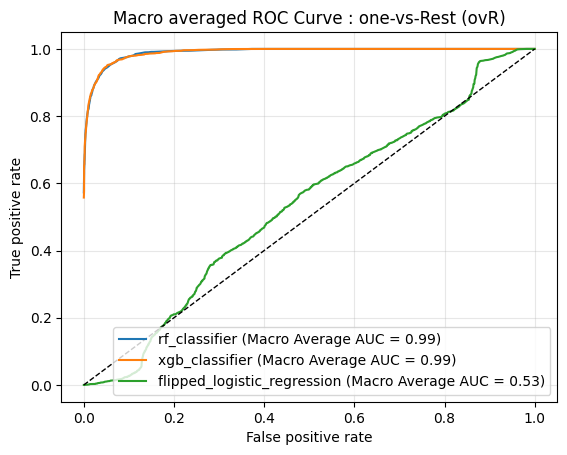

In [18]:
classes_enc=np.unique(y_train_enc)
y_test_enc_bin=label_binarize(y_test_enc, classes=classes_enc)

plt.figure()
for name, model in bonus_models.items():
  model.fit(X_train_scaled, y_train_enc)
  y_score=model.predict_proba(X_test_scaled)
  fpr_dict={}
  tpr_dict={}
  roc_auc_dict={}
  for i in range(len(classes_enc)):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_enc_bin[:, i], y_score[:, i])
    roc_auc_dict[i]=auc(fpr_dict[i], tpr_dict[i])
  all_fpr=np.unique(np.concatenate([fpr_dict[i] for i in range(len(classes_enc))]))
  mean_tpr=np.zeros_like(all_fpr)
  for i in range(len(classes_enc)):
    mean_tpr+=np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
  mean_tpr/=len(classes)
  roc_auc_macro=auc(all_fpr, mean_tpr)
  plt.plot(all_fpr, mean_tpr, label=f'{name} (Macro Average AUC = {roc_auc_macro:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Macro averaged ROC Curve : one-vs-Rest (ovR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

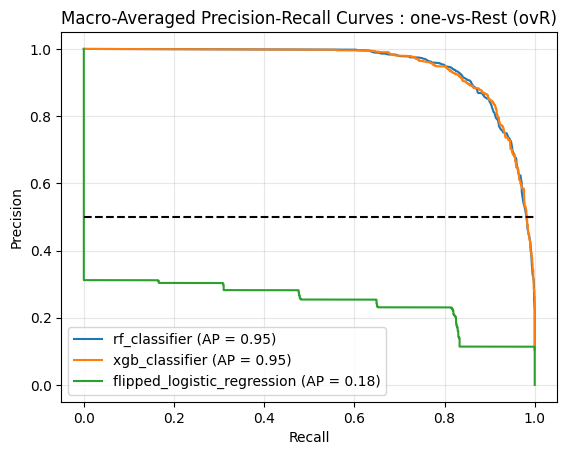

In [19]:
plt.figure()
for name, model in bonus_models.items():
  model.fit(X_train_scaled, y_train_enc)
  y_score=model.predict_proba(X_test_scaled)
  precision=dict()
  recall=dict()
  avg_precision=dict()
  for i in range(len(classes_enc)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_enc_bin[:, i], y_score[:, i])
    avg_precision[i]=average_precision_score(y_test_enc_bin[:, i], y_score[:, i])

  all_precision=np.unique(np.concatenate([precision[i] for i in range(len(classes_enc))]))
  mean_recall=np.zeros_like(all_precision)
  for i in range(len(classes_enc)):
    mean_recall+=np.interp(all_precision, precision[i], recall[i])
  mean_recall/=len(classes)
  mean_ap=np.mean(list(avg_precision.values()))
  plt.plot(mean_recall, all_precision, label=f'{name} (AP = {mean_ap:.2f})')

plt.plot([0, 1], [0.5, 0.5], 'k--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision-Recall Curves : one-vs-Rest (ovR)")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

It is observed that XG Boost and Random Forest provide very similar classification performance, comparable to the best performing models previously analyzed. The Flipped Logistic Regression model surprisingly does not provide a macro averaged AUC < 0.5, indicating that the data across classes could be well balanced. However, the average precision score of the model (0.18) is very poor, confirming that the model performs poorly on the dataset